In [1]:
import numpy as np

In [2]:
#intensity of strong Fe I

y  = np.array([34.77112996, 37.03580572, 32.57541929, 34.15405589, 30.24151055,
       31.66082233, 32.2526387 , 32.1187106 , 32.50761599, 32.72830339,
       32.90960811, 34.42052307, 36.07734834, 37.26469396])

x = np.array([0.21660408, 0.41918853, 0.5344944 ,
       0.61508275, 0.66615696, 0.69995831, 0.71730956, 0.71977728,
       0.70678011, 0.67836311, 0.63217895, 0.56240407, 0.46130559,
       0.29557926])

yerr = np.array([1.7882215 , 1.15065759, 0.976062  , 0.71786259, 0.70084379,
       0.6103004 , 0.59827162, 0.60736476, 0.61606252, 0.61075072,
       0.67098637, 0.74394223, 0.90412985, 1.34603374])

In [58]:
from dynesty import NestedSampler

# ---------- LIKELIHOODS & PRIORS ----------
# Helper: log-likelihood for linear model (m, b)
def loglike_linear(theta, x, y, yerr):
    m, b, ln_j = theta
    j = np.exp(ln_j)
    var = yerr**2 + j**2
    model = m * x + b
    resid = y - model
    return -0.5 * np.sum(resid**2 / var + np.log(2*np.pi*var))

# Helper: log-likelihood for intercept-only (b) where m ≡ 0
def loglike_constant(theta, x, y, yerr):
    b, ln_j = theta
    j = np.exp(ln_j)
    var = yerr**2 + j**2
    model = b * np.ones_like(x)
    resid = y - model
    return -0.5 * np.sum(resid**2 / var + np.log(2*np.pi*var))


def ptform_linear(u, priors):
    m = priors[0][0] + (priors[0][1] - priors[0][0]) * u[0]
    b = priors[1][0] + (priors[1][1] - priors[1][0]) * u[1]
    ln_j = priors[2][0] + (priors[2][1] - priors[2][0]) * u[2]
    return np.array([m, b, ln_j])

def ptform_constant(u, priors):
    b = priors[1][0] + (priors[1][1] - priors[1][0]) * u[0]
    ln_j = priors[2][0] + (priors[2][1] - priors[2][0]) * u[1]
    return np.array([b, ln_j])

def ptform_positive_slope(u, priors):
    # positive slope: m in [0, m_max]
    m = 0 + (priors[0][1] - 0)*u[0]
    b = priors[1][0] + (priors[1][1] - priors[1][0])*u[1]
    ln_j = priors[2][0] + (priors[2][1] - priors[2][0]) * u[2]
    return np.array([m, b, ln_j])

def ptform_negative_slope(u, priors):
    # negative slope: m in [m_min, 0]
    m = priors[0][0] + (0 - priors[0][0])*u[0]
    b = priors[1][0] + (priors[1][1] - priors[1][0])*u[1]
    ln_j = priors[2][0] + (priors[2][1] - priors[2][0]) * u[2]
    return np.array([m, b, ln_j])



# ---------------------------------------------------
# Dynesty runner
# ---------------------------------------------------
def run_dynesty(loglike, ptform, ndim, maxiter=5000):
    sampler = NestedSampler(loglike, ptform, ndim, sample="rwalk")
    sampler.run_nested(maxiter=maxiter)
    return sampler.results


# ---------------------------------------------------
# MASTER FUNCTION
# ---------------------------------------------------
def compare_models(x, y, yerr, maxiter=5000):
    # reasonable priors based on the data
    m_min, m_max = -1e3, 1e3
    b_min, b_max = -1e3, 1e3
    ln_j_min, ln_j_max = np.log(1e-3 * np.median(yerr)), np.log(2 * np.median(yerr))
    priors = [(m_min, m_max), (b_min, b_max), (ln_j_min, ln_j_max)]

    # ----------------------
    # 1) Linear model m,b
    # ----------------------
    like_A = lambda th: loglike_linear(th, x, y, yerr)
    pt_A = lambda u: ptform_linear(u, priors)
    resA = run_dynesty(like_A, pt_A, ndim=3, maxiter=maxiter)

    # ----------------------
    # 2) Constant model (m=0)
    # ----------------------
    like_B = lambda th: loglike_constant(th, x, y, yerr)
    pt_B = lambda u: ptform_constant(u, priors)
    resB = run_dynesty(like_B, pt_B, ndim=2, maxiter=maxiter)

    logZ_A, logZerr_A = resA.logz[-1], resA.logzerr[-1]
    logZ_B, logZerr_B = resB.logz[-1], resB.logzerr[-1]
    logK_linear_vs_const = logZ_A - logZ_B

    print("\n========================")
    print("Linear vs Constant")
    print("========================")
    print(f"logZ(linear)   = {logZ_A:.3f} ± {logZerr_A:.3f}")
    print(f"logZ(constant) = {logZ_B:.3f} ± {logZerr_B:.3f}")
    print(f"log Bayes factor = {logK_linear_vs_const:.3f}")
    print("========================")

    # If linear not favored, stop
    if logK_linear_vs_const < 0:
        print("Linear model NOT favored -> stopping.")
        return resA, resB, None, None

    # ---------------------------------------------------
    # If linear is favored: compare sign of slope
    # ---------------------------------------------------
    # --- positive slope
    pt_pos = lambda u: ptform_positive_slope(u, priors)
    resPos = run_dynesty(lambda th: loglike_linear(th, x, y, yerr), pt_pos, ndim=3, maxiter=maxiter)

    # --- negative slope
    pt_neg = lambda u: ptform_negative_slope(u, priors)
    resNeg = run_dynesty(lambda th: loglike_linear(th, x, y, yerr), pt_neg, ndim=3, maxiter=maxiter)

    logZ_pos, logZerr_pos = resPos.logz[-1], resPos.logzerr[-1]
    logZ_neg, logZerr_neg = resNeg.logz[-1], resNeg.logzerr[-1]
    logK_sign = logZ_neg - logZ_pos

    print("\n========================")
    print("Positive vs Negative slope")
    print("========================")
    print(f"logZ(m>0)  = {logZ_pos:.3f} ± {logZerr_pos:.3f}")
    print(f"logZ(m<0)  = {logZ_neg:.3f} ± {logZerr_neg:.3f}")
    print(f"log Bayes factor = {logK_sign:.3f}")
    print("========================")

    return resA, resB, resPos, resNeg

In [59]:
resA, resB, resPos, resNeg = compare_models(x, y, yerr, maxiter=20000)

0it [00:00, ?it/s]

7745it [00:05, 1483.73it/s, +500 | bound: 12 | nc: 1 | ncall: 155052 | eff(%):  5.335 | loglstar:   -inf < -21.219 <    inf | logz: -35.976 +/-  0.168 | dlogz:  0.001 >  0.509]  
6036it [00:03, 1688.16it/s, +500 | bound: 10 | nc: 1 | ncall: 112593 | eff(%):  5.831 | loglstar:   -inf < -29.423 <    inf | logz: -40.669 +/-  0.144 | dlogz:  0.001 >  0.509]  



Linear vs Constant
logZ(linear)   = -35.976 ± 0.299
logZ(constant) = -40.669 ± 0.261
log Bayes factor = 4.693


9678it [00:06, 1609.66it/s, +500 | bound: 18 | nc: 1 | ncall: 200204 | eff(%):  5.097 | loglstar:   -inf < -29.476 <    inf | logz: -48.108 +/-  0.192 | dlogz:  0.001 >  0.509]   
7243it [00:04, 1686.42it/s, +500 | bound: 11 | nc: 1 | ncall: 143589 | eff(%):  5.411 | loglstar:   -inf < -21.211 <    inf | logz: -34.961 +/-  0.162 | dlogz:  0.001 >  0.509] 


Positive vs Negative slope
logZ(m>0)  = -48.108 ± 0.331
logZ(m<0)  = -34.961 ± 0.287
log Bayes factor = 13.147


In [60]:
# ---------- OPTIONAL: posterior samples (weights) ----------
# Example: get weighted samples for linear model
weights = np.exp(resNeg.logwt - resNeg.logz[-1])
samples = resNeg.samples  # shape (Nsamps, ndim)
# You can use these to compute parameter estimates (weighted mean, credible intervals)
print(samples.shape)

(7743, 3)


In [61]:
from dynesty.utils import resample_equal

posterior_samples = resample_equal(samples, weights)

In [62]:
labels = ["m", "b", "ln_j"]  # change depending on your model

for i, label in enumerate(labels):
    q50 = np.percentile(posterior_samples[:, i], 50)
    q16 = np.percentile(posterior_samples[:, i], 16)
    q84 = np.percentile(posterior_samples[:, i], 84)
    print(f"{label} = {q50:.4f} (+{q84 - q50:.4f}, -{q50 - q16:.4f})")

m = -12.1034 (+2.0522, -1.9542)
b = 40.6259 (+1.2151, -1.3109)
ln_j = -2.1157 (+1.7528, -3.4343)


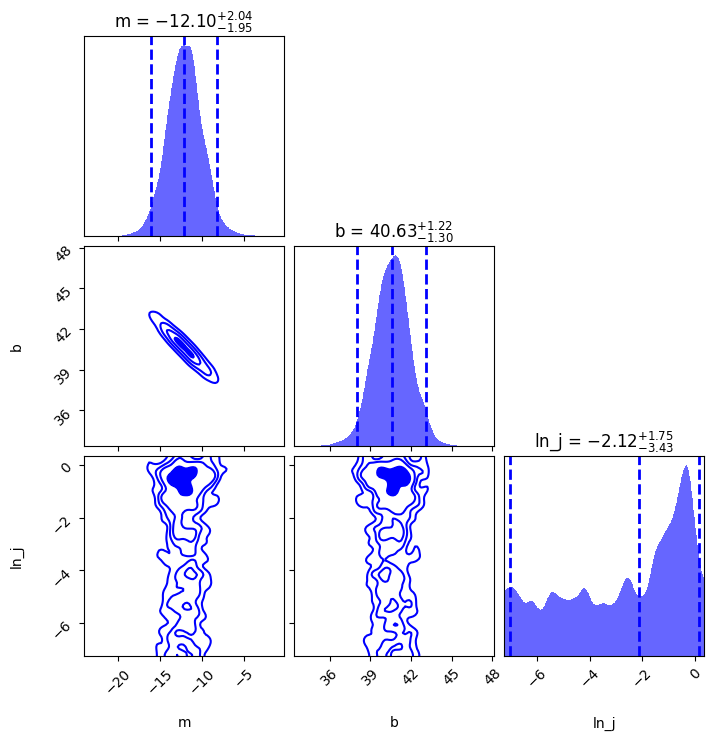

In [64]:
from dynesty import plotting as dyplot

fig, axes = dyplot.cornerplot(resNeg, color='blue', show_titles=True, labels=labels, title_quantiles=[0.16,0.5,0.84])

In [ ]:
import dynesty

# log-likelihood
def loglike(theta):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# prior transform
def prior_transform(utheta):
    um, ub, ulf = utheta
    m = -100 + 200 * um  # m in [-100, +100]
    b = -100 + 200 * ub # b in [-100, +100]
    lnf = -5 + 5 * ulf # lnf in [-5, +5]
    return m, b, lnf

dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3, bound='multi', sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

16517it [00:11, 1487.22it/s, batch: 7 | bound: 3 | nc: 1 | ncall: 334002 | eff(%):  4.788 | loglstar: -13.613 < -8.291 < -9.262 | logz: -18.864 +/-  0.082 | stop:  0.893]          


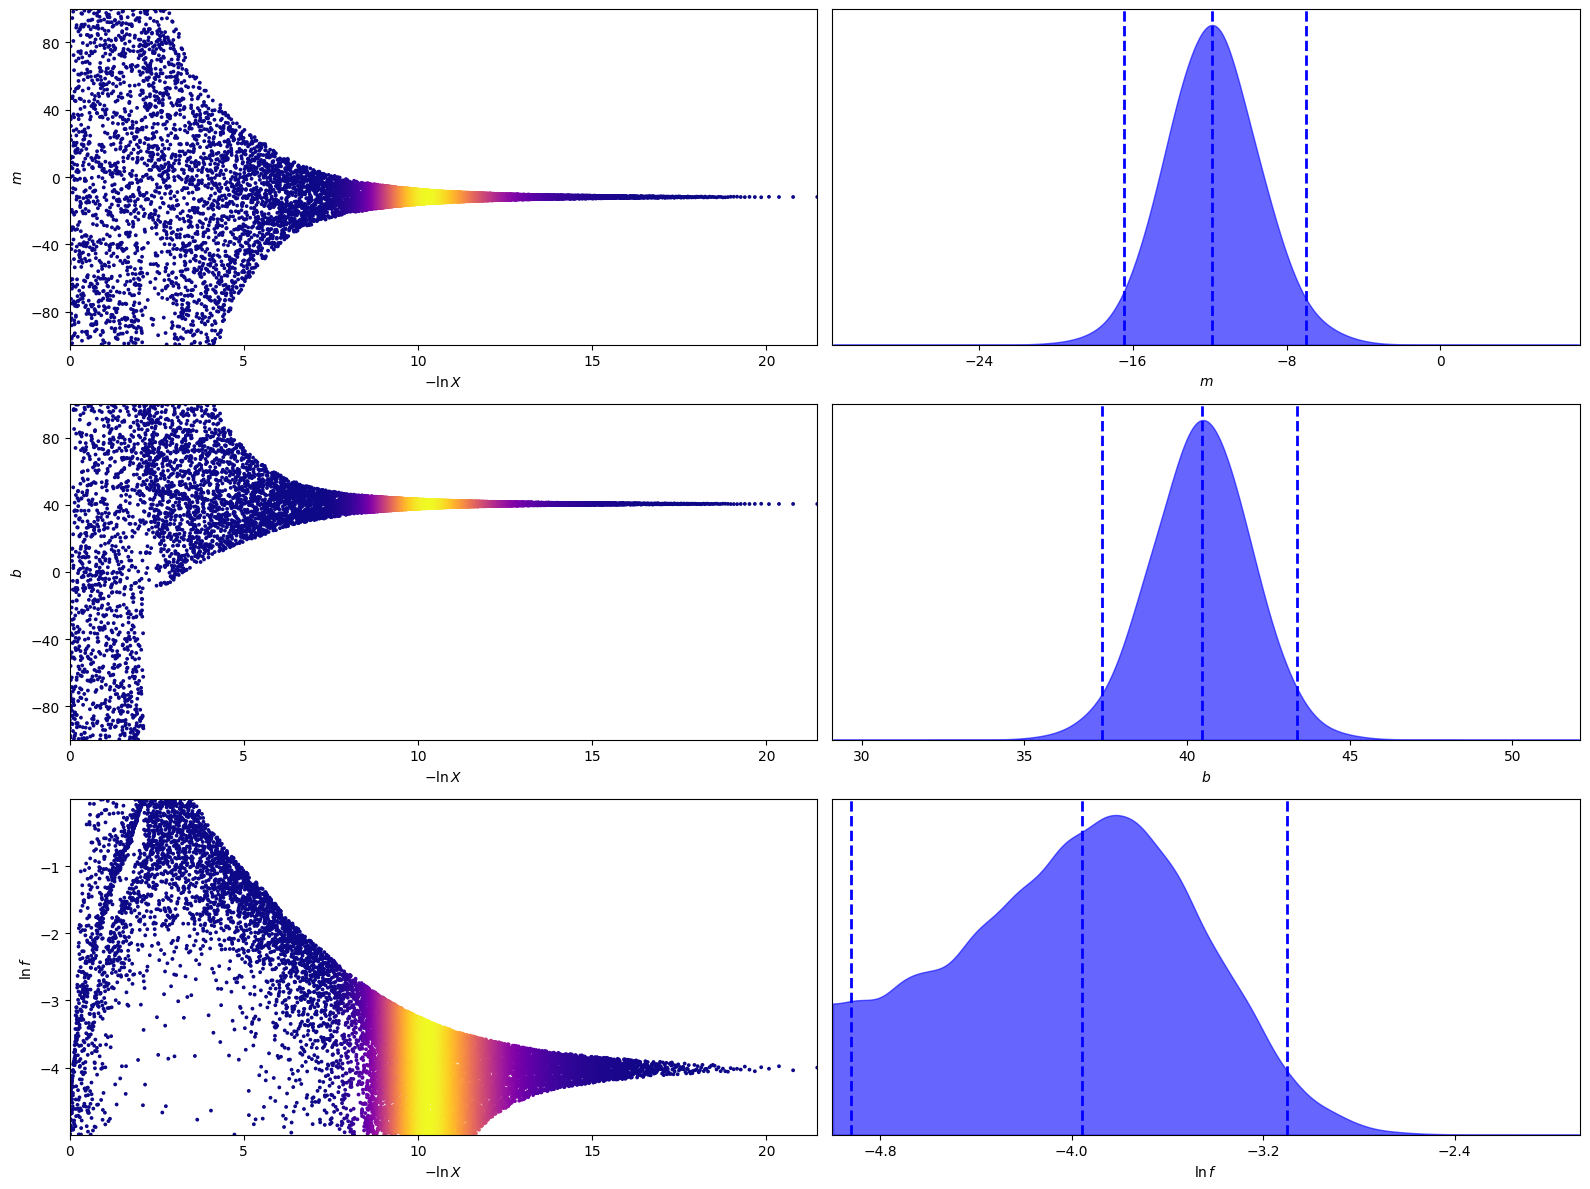

In [81]:
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

labels = [r'$m$', r'$b$', r'$\ln f$']
fig, axes = dyplot.traceplot(dsampler.results, labels=labels, fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

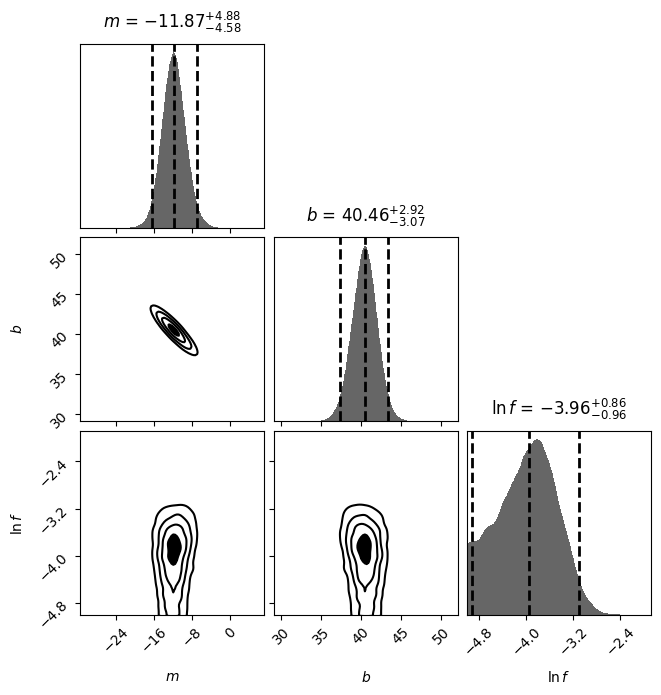

In [82]:

fig, axes = dyplot.cornerplot(dres, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(7, 7)))

In [5]:
from dynesty import DynamicNestedSampler
import numpy as np
import matplotlib.pyplot as plt

#intensity of strong Fe I

y  = np.array([34.77112996, 37.03580572, 32.57541929, 34.15405589, 30.24151055,
       31.66082233, 32.2526387 , 32.1187106 , 32.50761599, 32.72830339,
       32.90960811, 34.42052307, 36.07734834, 37.26469396])

x = np.array([0.21660408, 0.41918853, 0.5344944 ,
       0.61508275, 0.66615696, 0.69995831, 0.71730956, 0.71977728,
       0.70678011, 0.67836311, 0.63217895, 0.56240407, 0.46130559,
       0.29557926])

yerr = np.array([1.7882215 , 1.15065759, 0.976062  , 0.71786259, 0.70084379,
       0.6103004 , 0.59827162, 0.60736476, 0.61606252, 0.61075072,
       0.67098637, 0.74394223, 0.90412985, 1.34603374])

In [ ]:
# ---------- LIKELIHOODS & PRIORS ----------
# log-likelihood
def loglike_linear(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))

# log-likelihood for intercept-only (b) where m ≡ 0
def loglike_constant(theta, x, y, yerr):
    b, lnf = theta
    model = b
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((y-model)**2 * inv_sigma2 - np.log(inv_sigma2)))


# prior transform
def ptform_linear(utheta):
    um, ub, ulf = utheta
    m = -100 + 200 * um  # m in [-100, +100]
    b = -100 + 200 * ub # b in [-100, +100]
    lnf = -7 + 8*ulf # lnf in [-7, +1]
    return m, b, lnf

def ptform_constant(utheta):
    ub, ulf = utheta
    b = -100 + 200 * ub # b in [-100, +100]
    lnf = -7 + 8*ulf # lnf in [-7, +1]
    return b, lnf

def ptform_positive_slope(utheta):
    # positive slope: m in [0, m_max]
    um, ub, ulf = utheta
    m = 0 + 100 * um  # m in [0, +100]
    b = -100 + 200 * ub # b in [-100, +100]
    lnf = -7 + 8*ulf # lnf in [-7, +1]
    return m, b, lnf

def ptform_negative_slope(utheta):
    # positive slope: m in [0, m_max]
    um, ub, ulf = utheta
    m = -100 + 100 * um  # m in [-100, 0]
    b = -100 + 200 * ub # b in [-100, +100]
    lnf = -7 + 8*ulf # lnf in [-7, +1]
    return m, b, lnf


# Dynesty runner
def run_dynesty(loglike, ptform, ndim):
    dsampler = DynamicNestedSampler(loglike, ptform, ndim, bound='multi', sample='rwalk')
    dsampler.run_nested()
    return dsampler.results


# MASTER FUNCTION
def compare_models(x, y, yerr):
    # 1) Linear model m,b
    like_A = lambda th: loglike_linear(th, x, y, yerr)
    pt_A = lambda u: ptform_linear(u)
    resA = run_dynesty(like_A, pt_A, ndim=3)

    # 2) Constant model (m=0)
    like_B = lambda th: loglike_constant(th, x, y, yerr)
    pt_B = lambda u: ptform_constant(u)
    resB = run_dynesty(like_B, pt_B, ndim=2)

    logZ_A, logZerr_A = resA.logz[-1], resA.logzerr[-1]
    logZ_B, logZerr_B = resB.logz[-1], resB.logzerr[-1]
    logK_linear_vs_const = logZ_A - logZ_B

    print("\n========================")
    print("Linear vs Constant")
    print("========================")
    print(f"logZ(linear)   = {logZ_A:.3f} ± {logZerr_A:.3f}")
    print(f"logZ(constant) = {logZ_B:.3f} ± {logZerr_B:.3f}")
    print(f"log Bayes factor = {logK_linear_vs_const:.3f}")
    print("========================")

    # If linear not favored, stop
    if logK_linear_vs_const < 0:
        print("Linear model NOT favored -> stopping.")
        return resA, resB, None, None

    # If linear is favored: compare sign of slope
    # --- positive slope
    pt_pos = lambda u: ptform_positive_slope(u)
    resPos = run_dynesty(lambda th: loglike_linear(th, x, y, yerr), pt_pos, ndim=3)
    # --- negative slope
    pt_neg = lambda u: ptform_negative_slope(u)
    resNeg = run_dynesty(lambda th: loglike_linear(th, x, y, yerr), pt_neg, ndim=3)

    logZ_pos, logZerr_pos = resPos.logz[-1], resPos.logzerr[-1]
    logZ_neg, logZerr_neg = resNeg.logz[-1], resNeg.logzerr[-1]
    logK_sign = logZ_neg - logZ_pos

    print("\n========================")
    print("Positive vs Negative slope")
    print("========================")
    print(f"logZ(m>0)  = {logZ_pos:.3f} ± {logZerr_pos:.3f}")
    print(f"logZ(m<0)  = {logZ_neg:.3f} ± {logZerr_neg:.3f}")
    print(f"log Bayes factor = {logK_sign:.3f}")
    print("========================")

    return resA, resB, resPos, resNeg

In [58]:
resA, resB, resPos, resNeg = compare_models(x, y, yerr)

16432it [00:10, 1505.85it/s, batch: 7 | bound: 3 | nc: 1 | ncall: 332931 | eff(%):  4.778 | loglstar: -13.665 < -8.308 < -9.363 | logz: -18.938 +/-  0.083 | stop:  0.892]          
15717it [00:11, 1402.29it/s, batch: 8 | bound: 3 | nc: 1 | ncall: 303508 | eff(%):  5.005 | loglstar: -21.660 < -16.340 < -16.690 | logz: -23.651 +/-  0.065 | stop:  0.868]       



Linear vs Constant
logZ(linear)   = -18.931 ± 0.079
logZ(constant) = -23.669 ± 0.061
log Bayes factor = 4.738


16788it [00:10, 1622.43it/s, batch: 6 | bound: 5 | nc: 1 | ncall: 339753 | eff(%):  4.786 | loglstar: -22.440 < -16.350 < -17.020 | logz: -28.135 +/-  0.096 | stop:  0.878]         
15475it [00:09, 1573.32it/s, batch: 7 | bound: 4 | nc: 1 | ncall: 309355 | eff(%):  4.831 | loglstar: -13.426 < -8.305 < -9.140 | logz: -18.265 +/-  0.082 | stop:  0.966]          



Positive vs Negative slope
logZ(m>0)  = -28.138 ± 0.085
logZ(m<0)  = -18.269 ± 0.076
log Bayes factor = 9.868


In [59]:
# ---------- OPTIONAL: posterior samples (weights) ----------
# Example: get weighted samples for linear model
weights = np.exp(resNeg.logwt - resNeg.logz[-1])
samples = resNeg.samples  # shape (Nsamps, ndim)
# You can use these to compute parameter estimates (weighted mean, credible intervals)
print(samples.shape)

(15475, 3)


In [60]:
from dynesty.utils import resample_equal

posterior_samples = resample_equal(samples, weights)

In [61]:
labels = ["m", "b", "ln_j"]  # change depending on your model

for i, label in enumerate(labels):
    q50 = np.percentile(posterior_samples[:, i], 50)
    q16 = np.percentile(posterior_samples[:, i], 16)
    q84 = np.percentile(posterior_samples[:, i], 84)
    print(f"{label} = {q50:.4f} (+{q84 - q50:.4f}, -{q50 - q16:.4f})")

m = -11.9864 (+2.2123, -2.1782)
b = 40.5444 (+1.3939, -1.3967)
ln_j = -4.2825 (+0.6847, -1.5883)


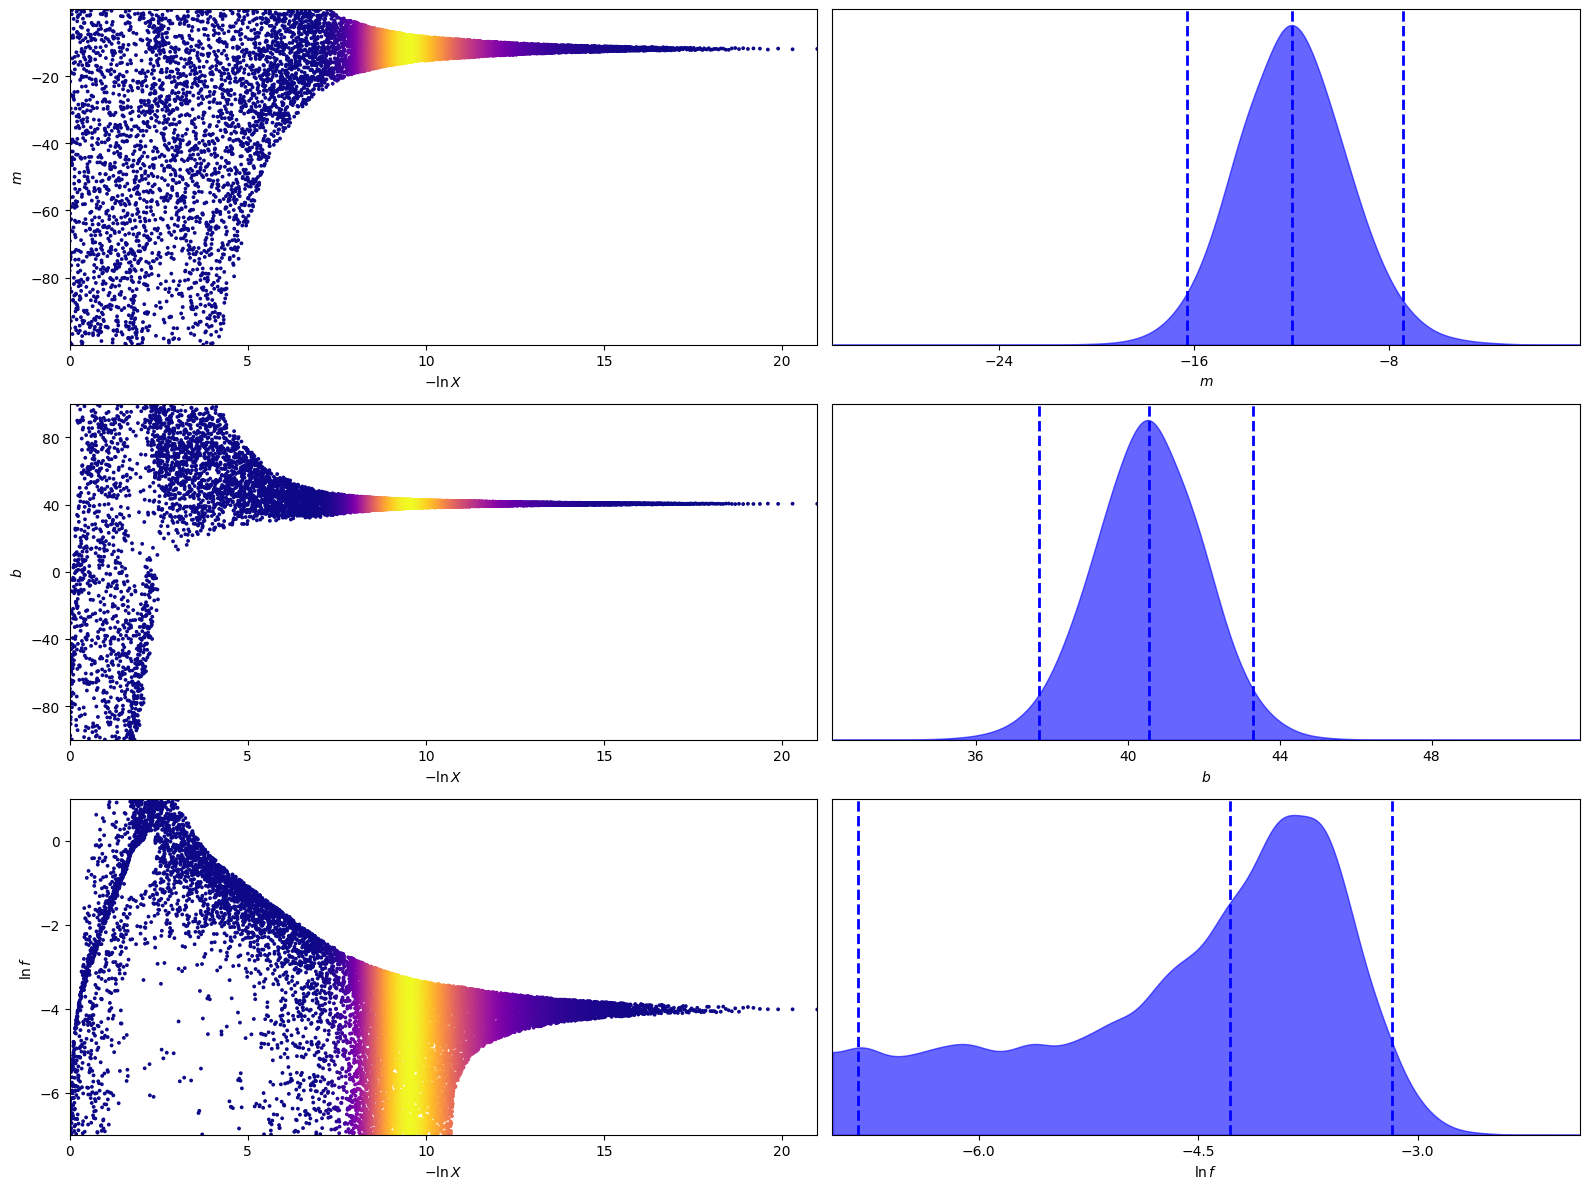

In [62]:
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

labels = [r'$m$', r'$b$', r'$\ln f$']
fig, axes = dyplot.traceplot(resNeg, labels=labels, fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

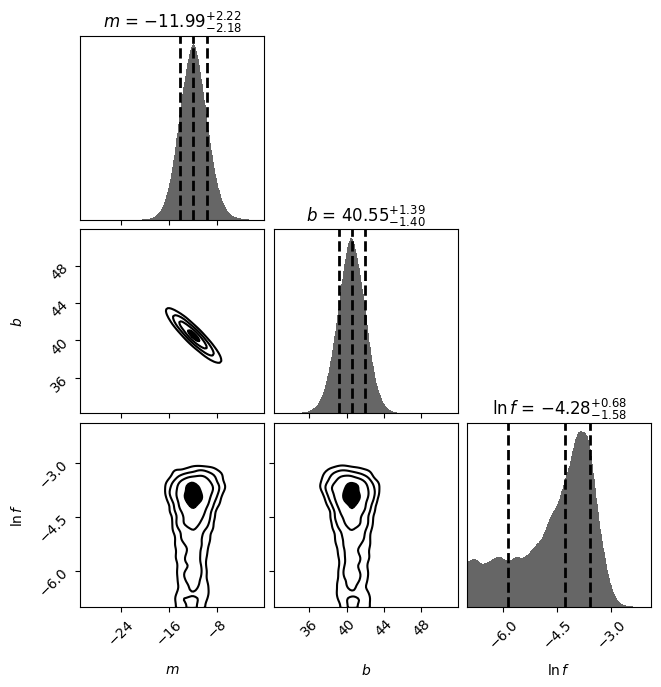

In [ ]:
fig, axes = dyplot.cornerplot(resNeg, show_titles=True, labels=labels, fig=plt.subplots(3, 3, figsize=(7, 7)), quantiles=(0.16,0.5,0.84), title_quantiles=[0.16,0.5,0.84])

In [1]:
import numpy as np

#intensity of strong Fe I

y  = np.array([34.77112996, 37.03580572, 32.57541929, 34.15405589, 30.24151055,
       31.66082233, 32.2526387 , 32.1187106 , 32.50761599, 32.72830339,
       32.90960811, 34.42052307, 36.07734834, 37.26469396])

x = np.array([0.21660408, 0.41918853, 0.5344944 ,
       0.61508275, 0.66615696, 0.69995831, 0.71730956, 0.71977728,
       0.70678011, 0.67836311, 0.63217895, 0.56240407, 0.46130559,
       0.29557926])

yerr = np.array([1.7882215 , 1.15065759, 0.976062  , 0.71786259, 0.70084379,
       0.6103004 , 0.59827162, 0.60736476, 0.61606252, 0.61075072,
       0.67098637, 0.74394223, 0.90412985, 1.34603374])

15749it [00:38, 411.38it/s, batch: 7 | bound: 4 | nc: 1 | ncall: 316583 | eff(%):  4.808 | loglstar: -13.478 < -8.277 < -8.718 | logz: -18.686 +/-  0.088 | stop:  0.966]               
16095it [00:35, 456.45it/s, batch: 8 | bound: 4 | nc: 1 | ncall: 312098 | eff(%):  4.989 | loglstar: -21.700 < -16.340 < -16.626 | logz: -23.835 +/-  0.065 | stop:  0.854]             



Linear vs Constant
logZ(linear)   = -18.682 ± 0.078
logZ(constant) = -23.829 ± 0.061
log Bayes factor = 5.147
Unconstrained model favored.


17163it [00:35, 488.19it/s, batch: 6 | bound: 5 | nc: 1 | ncall: 348337 | eff(%):  4.776 | loglstar: -22.417 < -16.360 < -17.075 | logz: -28.477 +/-  0.095 | stop:  0.859]             
14932it [00:33, 444.88it/s, batch: 7 | bound: 3 | nc: 1 | ncall: 297260 | eff(%):  4.844 | loglstar: -13.324 < -8.277 < -9.403 | logz: -18.147 +/-  0.083 | stop:  0.992]               


Positive vs Negative slope
logZ(m>0)  = -28.480 ± 0.085
logZ(m<0)  = -18.142 ± 0.078
log Bayes factor = 10.338
Negative slope favored.
m = -11.986617117831663 +/- 2.1779721993122028
b = 40.545551330826015 +/- 1.3805389366304688
ln_f = -4.286550079330173 +/- 1.1585890877285097


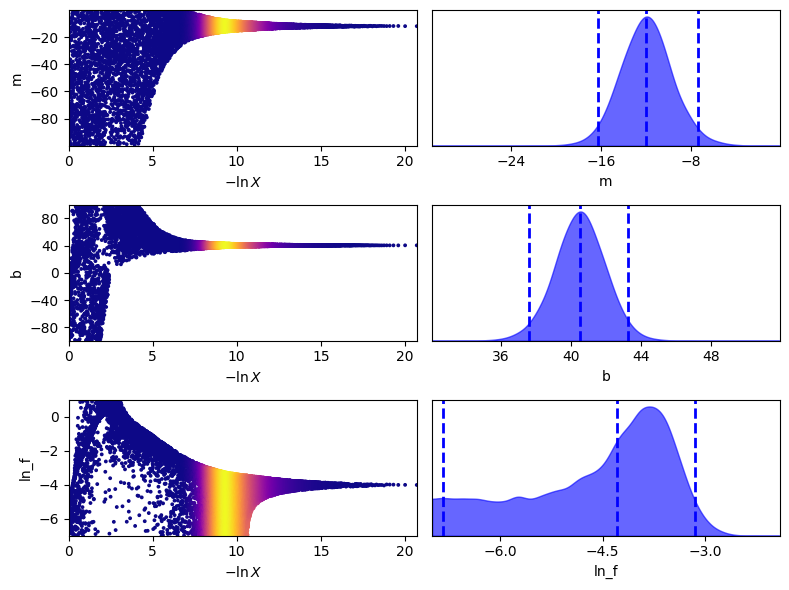

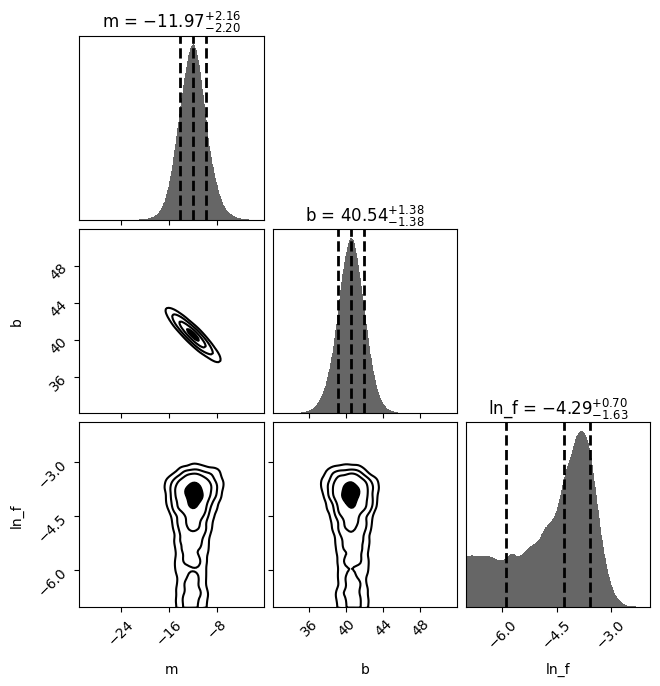

In [2]:
from nested_sampling import run_nestedsampler

linear_fit_params, model = run_nestedsampler(x, y, yerr).results